## Homework 4: Mean Shift Segmentation

**Due date:** May 4, 2023

The goal of the assignment is to implement the mean shift algorithm and use it for image segmentation. You should return the completed notebook, including answers and illustrations. 


**Part 1: mean shift on synthetic data**

* Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.
* Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.
* Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.
* Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.
* Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.
* Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.
* Experiment with your code by changing the data distribution, the kernel, and and bandwidth vector.

**Part 2: mean shift for image segmentation**

* For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1QECmvrczTR4ezTvkQMZyDuLjFNquFatX/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 
* Convert the (N,M,3) image into an (NM,5) matrix including color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?
* Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from skimage.color import rgb2lab,lab2rgb
import random
import cv2
import matplotlib.pyplot as plt
from time import time

Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.

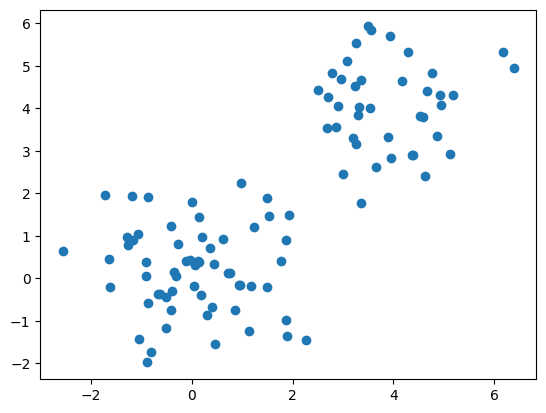

In [2]:
max_iter = 1000
np.random.seed(0)

# generating the synthetic dataset
mean1 = np.zeros(2)
cov1 = np.eye(2) # unit covariance, np.eye: return a 2d array with ones on the diagonal and zeros elsewhere
mean2 = np.array([4, 4]) 
cov2 = np.eye(2) # unit covariance
# draw random samples from a multivariate normal distribution
data1 = np.random.multivariate_normal(mean1, cov1, size = 60) # 60 points sampled from a Gaussian distribution of unit covariance centered in (0, 0)   
data2 = np.random.multivariate_normal(mean2, cov2, size = 40) # 40 points sampled from a Gaussian with unit covariance centered in (4, 4)
data = np.vstack([data1, data2])

# visualizing the dataset
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.

computer vision, ponce p.274
\begin{align*}
K(x, h) &= \frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
\frac{\partial K(x, h)}{\partial x} &= \left(-\frac{1}{2}\frac{2\|x\|}{h}\right)\frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
&= -\frac{\|x\|}{h}\frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
\end{align*}

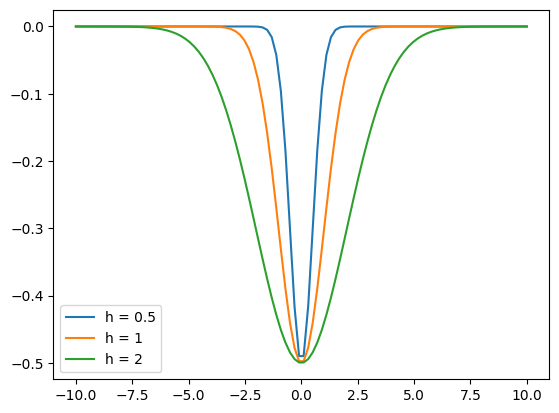

In [3]:
def gaussian_kernel_function(r): # Fukunaga 1975, p.30
    return math.exp(-0.5 * r)
    
def epanechnikov_kernel_function(r): # Fukunaga 1975, p.30
    return 0.75 * (1 - r)

def gaussian_kernel_first_derivative(r):
    return -0.5 * math.exp(-0.5 * r)

def derivative(r):
    if r > 1: return 0
    else: return 1

def kernel(x, h, derivative = "gaussian"):
    norm_x = np.linalg.norm(x) ** 2 / h ** 2
    if derivative == "gaussian":
        g = gaussian_kernel_first_derivative(norm_x)
        # g = -2 * np.exp(-0.5 * norm_x) / (np.sqrt(2 * np.pi) * h ** 3)
    elif derivative == "epanechnikov":
        if norm_x < 1:
            g = epanechnikov_kernel_function(norm_x)
            # g = 3 / (4 * np.pi * h ** 5) * (1 - norm_x)
        else:
            g = 0
    return g

x_range = np.linspace(-10, 10, 100)
h_values = [0.5, 1, 2]

for h in h_values:
    g_values = [kernel(np.array([x]), h) for x in x_range]
    plt.plot(x_range, g_values, label = f"h = {h}")
plt.legend()
plt.show()

Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.

In [4]:
def ms_step(x, data, h):
    num = 0
    denom = 0
    for i in range(data.shape[0]):
        diff = (x - data[i]) / h
        k = kernel(diff, h)
        num += k * data[i]
        denom += k
    return num / denom

def MS_step(x, data, h):
    shift = np.zeros_like(x)
    weight_sum = 0.0
    for point in data:
        weight = derivative(gaussian_kernel_function((x - point) / h))
        shift += point * weight
        weight_sum += weight
    if weight_sum == 0.0:
        return x
    else:
        return (shift / weight_sum).astype('int')

Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.

In [5]:
def ms_point(x, data, h, eps = 1e-5):
    while True:
        x_new = ms_step(x, data, h)
        # print('x_new', x_new)
        if np.linalg.norm(x_new - x) < eps:
            break
        x = x_new
    return x_new

def euclidean_distance(a, b):
    return np.sqrt(np.sum(a - b) ** 2)

max_iter = 1000
range_threshold = 10.0
def MS_point(data, h):
    first_point = data[0]
    last_centroid = first_point
    iteration = 0
    while iteration < max_iter:
        iteration += 1
        centroid = MS_step(last_centroid, data, h)
        distance = euclidean_distance(last_centroid, centroid)
        if distance < range_threshold or np.all(centroid == last_centroid): break
        last_centroid = centroid
    return centroid

Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.

In [6]:
def shift(data, h, eps = 1e-5, dist_thresh = 0.1):
    modes = []
    labels = np.zeros(data.shape[0], dtype = int)
    for i in range(data.shape[0]):
        print(f'data[{i}] = {data[i]}')
        if labels[i] == 0:
            x = ms_point(data[i], data, h)
            # print('x = ', x)
            label = len(modes) + 1
            for j in range(len(modes)):
                # print(f'mode[{j}] = {modes[j]}')
                if np.linalg.norm(x - modes[j]) < dist_thresh * np.sum(h):
                    label = j + 1
                    break
            modes.append(x)
            labels[i] = label
    return modes, labels

spacial_threshold = 2.0
min_region_size = 5
def mean_shift(image, regions):
    spatial_centroids = []
    range_centroids = []
    for region in regions:
        c = MS_point(region[:,:2], spacial_threshold)
        spatial_centroids.append(np.rint(c).astype(int))
        range_centroids.append(region[0][2:])
    #print "Centroids Computed = ",len(spatial_centroids)
    spatial_centroids = np.array(spatial_centroids)
    range_centroids = np.array(range_centroids)
    lookup_matrix = np.zeros((image.shape[0], image.shape[1])).astype(int)
    labels = {}
    for i,centroid in enumerate(spatial_centroids):
        lookup_matrix[centroid[0],centroid[1]] = i
        labels[i] = i
    visited = {}
    #print lookup_matrix[0,0]
    indexes = range(len(spatial_centroids))
    random.seed(0)
    random.shuffle(indexes)
    for i in indexes:
        visited[i] = True
        #print visited
        window = get_centroid_window(lookup_matrix, spatial_centroids[i], visited, spatial_centroids, range_centroids)
        
        for r in window:
            labels[r] = labels[i]
    region_groups = {}
    for k,v in labels.items():
        if v not in region_groups:
            region_groups[v] = [k]
        else:
            region_groups[v].append(k)
    final_regions = []
    
    for k,group in region_groups.items():
        merged_group = None
        for region in group:
            if not np.all(merged_group):
                merged_group = regions[region]
            else:
                #print "Existing: ",merged_group.shape
                #print "New: ",regions[region].shape
                merged_group = np.vstack([merged_group,regions[region]])
        final_regions.append(merged_group)
    for region in final_regions:
        new_centroid = MS_point(region[:,2:], range_threshold)
        region[:,2:] = new_centroid
    #print "Final Regions: ",len(final_regions)
    temp = []
    for region in final_regions:
        if len(region) < min_region_size and len(temp) > 1:
            region[:,2:] = temp[-1][0][2:]
            temp[-1] = np.vstack([temp[-1], region])
        else:
            temp.append(region)
    final_regions = temp
    return final_regions

auxillary_grid = []
def get_centroid_window(lookup_matrix, centroid, visited, spatial_centroids, range_centroids):
    left_limit = centroid[0] - spacial_threshold
    right_limit = centroid[0] + spacial_threshold +1
    top_limit = centroid[1] - spacial_threshold
    bottom_limit = centroid[1] + spacial_threshold +1
    if left_limit < 0:
        left_limit = 0
    if right_limit > auxillary_grid.shape[0]:
        right_limit = auxillary_grid.shape[0]
    if top_limit < 0:
        top_limit = 0
    if bottom_limit > auxillary_grid.shape[1]:
        bottom_limit = auxillary_grid.shape[1]
    result = []
    centroid_region = lookup_matrix[centroid[0],centroid[1]]
    for i in range(left_limit, right_limit):
        for j in range(top_limit, bottom_limit):
            if lookup_matrix[i,j] != 0 and lookup_matrix[i,j] not in visited:
                #print lookup_matrix[i,j]
                if euclidean_distance(range_centroids[centroid_region], range_centroids[lookup_matrix[i,j]]) < self.__range_threshold:
                    result.append(lookup_matrix[i,j])
    return result

In [7]:
def __getImageVector(image):
    pixel_values = image.reshape(-1, image.shape[-1])
    rows, columns, channels = image.shape
    pixel_coords = np.zeros((rows, columns, 2))
    for i in range(0,rows):
        for j in range(0,columns):
            pixel_coords[i,j] = np.array([i,j])
    pixel_coords = pixel_coords.reshape(pixel_coords.shape[0]*pixel_coords.shape[1], pixel_coords.shape[-1])
    image_vector = np.hstack([pixel_coords, pixel_values])
    return image_vector

In [8]:
# modes, labels = shift(data, h = np.array([1, 1]))
# plt.scatter(data[:, 0], data[:, 1], c = labels)
# plt.scatter([m[0] for m in modes], [m[1] for m in modes], marker = "x", s = 200, color = "red")
# plt.show()

For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1QECmvrczTR4ezTvkQMZyDuLjFNquFatX/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Lab Image')

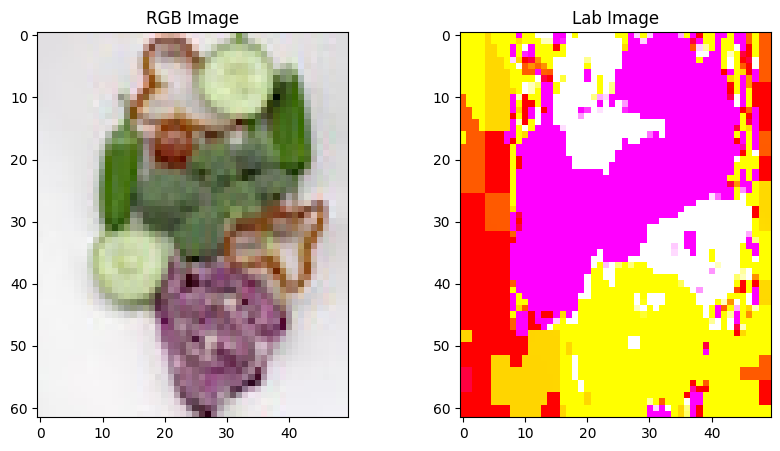

In [9]:
from skimage import io, color

img = io.imread('veggies_small.jpg')
img_lab = color.rgb2lab(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow(img)
ax1.set_title('RGB Image')

# Plot the Lab image
ax2.imshow(img_lab)
ax2.set_title('Lab Image')

Convert the (N,M,3) image into an (NM,5) matrix including color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?

In [10]:
N, M, _ = img_lab.shape
x, y = np.meshgrid(np.arange(M), np.arange(N))
xy = np.column_stack([img_lab.reshape(N*M, 3), x.reshape(N*M), y.reshape(N*M)])
print(xy)

[[89.05178892  1.21117293 -1.22096119  0.          0.        ]
 [89.05178892  1.21117293 -1.22096119  1.          0.        ]
 [89.05178892  1.21117293 -1.22096119  2.          0.        ]
 ...
 [95.34656791  1.21980719 -2.28168737 47.         61.        ]
 [95.34656791  1.21980719 -2.28168737 48.         61.        ]
 [95.34656791  1.21980719 -2.28168737 49.         61.        ]]


Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

In [11]:
"""print('len(data) = ', len(xy))
modes, labels = shift(xy, h)

# Replace the color values of the pixels associated with each mode by the color of the mode
segmented_img = np.zeros_like(img_lab)
for i, mode in enumerate(modes):
    mask = labels == i
    segmented_img[mask] = mode[:3]
    # print(segmented_img[mask])

# Convert back to RGB colorspace for visualization
segmented_img_rgb = color.lab2rgb(segmented_img)"""

"print('len(data) = ', len(xy))\nmodes, labels = shift(xy, h)\n\n# Replace the color values of the pixels associated with each mode by the color of the mode\nsegmented_img = np.zeros_like(img_lab)\nfor i, mode in enumerate(modes):\n    mask = labels == i\n    segmented_img[mask] = mode[:3]\n    # print(segmented_img[mask])\n\n# Convert back to RGB colorspace for visualization\nsegmented_img_rgb = color.lab2rgb(segmented_img)"

In [13]:
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(img)
# axs[0].set_title('Original Image')
# axs[1].imshow(segmented_img_rgb)
# axs[1].set_title('Segmented Image')
# plt.show()

In [16]:
def overlay_borders(image):
    edges = cv2.Canny(image, 20, 240)
    return cv2.addWeighted(image, 1.0, np.dstack((edges,edges,edges)), 1.0,0)

image_vector = []
def __filter(image):
    image_vector = __getImageVector(image)
    auxillary_grid = np.arange(0,len(image_vector)).reshape(image.shape[0], image.shape[1])
    pixel_ids = range(0,len(image_vector))
    pixels_to_process = dict.fromkeys(pixel_ids)
    
    regions = []
    
    while len(pixels_to_process) > 0:
        random_pixel_tuple = pixels_to_process.popitem()
        #print "Random Pixel: ",random_pixel_tuple
        #Fill in the code below - locally; do "popitem()" for each pixel you add to window
        window = __getPixelWindow(random_pixel_tuple[0], pixels_to_process)
        window_values = __getWindowValues(window)
        window_centroid_value = MS_point(window_values, range_threshold)
        for pixel in window:
            if window_centroid_value[0] < 0:
                window_centroid_value[0] += 255
            if window_centroid_value[1] < 0:
                window_centroid_value[1] += 255
            if window_centroid_value[2] < 0:
                window_centroid_value[2] += 255
            
            if window_centroid_value[0] > 255:
                window_centroid_value[0] = 255
            if window_centroid_value[1] > 255:
                window_centroid_value[1] = 255
            if window_centroid_value[2] > 255:
                window_centroid_value[2] = 255
            
            pixel[2] = window_centroid_value[0]
            pixel[3] = window_centroid_value[1]
            pixel[4] = window_centroid_value[2]
        regions.append(window)
    return regions

def __getPixelWindow(random_pixel_id, pixels_to_process):
    random_pixel = image_vector[random_pixel_id]
    #print "Random Pixel Value: ", random_pixel
    random_pixel_x = random_pixel[0]
    random_pixel_y = random_pixel[1]
    left_limit = int(random_pixel_x - spacial_threshold)
    right_limit = int(random_pixel_x + spacial_threshold)
    top_limit = int(random_pixel_y - spacial_threshold)
    bottom_limit = int(random_pixel_y + spacial_threshold)
    if left_limit < 0:
        left_limit = 0
    if right_limit > auxillary_grid.shape[0]:
        right_limit = auxillary_grid.shape[0]
    if top_limit < 0:
        top_limit = 0
    if bottom_limit > auxillary_grid.shape[1]:
        bottom_limit = auxillary_grid.shape[1]
    frame = auxillary_grid[left_limit:right_limit, top_limit:bottom_limit]
    frame = frame.ravel()
    nframe = []
    for pixel_id in frame:
        if pixel_id == random_pixel_id or pixel_id not in pixels_to_process:
            continue
        nframe.append(pixel_id)
    frame = np.array(nframe)
    
    if frame.size ==0:
        return np.array([random_pixel])
    #print "Frame Ravel: ",frame
    frame_pixel_values = image_vector[frame][:,2:]
    #print "Frame Values: ",frame_pixel_values
    frame_pixel_values -= random_pixel[2:]
    #print "After Subtraction: ", frame_pixel_values
    frame_pixel_values **=2
    frame_pixel_distances = np.sqrt(np.sum(frame_pixel_values, axis=1))
    
    frame = frame[frame_pixel_distances <= range_threshold]
    #print "Distances: ", frame_pixel_distances
    for pixel_id in frame:
        pixels_to_process.pop(pixel_id)
    if frame.size ==0:
        return np.array([random_pixel])
    return np.vstack([image_vector[frame], random_pixel])

def __getWindowValues(window):
    return window[:,2:]

def __regionsToImage(image,regions):
    result = np.empty_like(image)
    for region in regions:
        for pixel in region:
            result[int(pixel[0]),int(pixel[1])] = pixel[2:]
    return result

def __overlayBorders(image):
    edges = cv2.Canny(image, 20, 240)
    return cv2.addWeighted(image, 1.0, np.dstack((edges,edges,edges)), 1.0,0)

def segment(image):
    print("Beginning segmentation process..")
    tf = time()
    regions = __filter(image)
    print("Completed filtering in ",round(time()-tf,2)," seconds")
    tm = time()
    m_regions = mean_shift(image, regions)
    print("Completed region merging in ",round(time()-tm,2)," seconds")
    result = __regionsToImage(image,m_regions)
    return result, __overlayBorders(result)

In [17]:
im = cv2.cvtColor(cv2.imread('veggies_small.jpg'), cv2.COLOR_BGR2RGB)

result, result_with_borders = segment(im)

def display_image(image):
    #plt.set_cmap('gray')
    plt.axis("off")
    plt.imshow(image)
    plt.show()

display_image(im)
display_image(result)
display_image(result_with_borders)

Beginning segmentation process..


IndexError: list index out of range